<a href="https://colab.research.google.com/github/tavakohr/rprojects/blob/main/calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython
from google.colab import files

In [26]:
%%R
if (!require("moments")) install.packages("remotes")
if (!require("moments")) remotes::install_github("feralaes/dampack")

In [27]:
%%R
if (!require("moments")) install.packages("moments")


In [28]:
%%R
library(tidyverse)
library(repr)
library(moments)
library(dampack)

## Create Original data set

In [5]:
%%R
x1 = rnorm(10000)           # some continuous variables
z = 2 + x1       # linear combination with a bias
pr = 1/(1+exp(-z))         # pass through an inv-logit function
y = rbinom(10000,1,pr)      # bernoulli response variable
print( paste('probability in original data set ' ,mean(pr)))

[1] "probability in original data set  0.845667583897545"


In [6]:
%%R
#now feed it to glm:
df1 = data.frame(y=y,x=x1)
model1<-glm( y~x,data=df1,family="binomial")
model1


Call:  glm(formula = y ~ x, family = "binomial", data = df1)

Coefficients:
(Intercept)            x  
     1.9924       0.9903  

Degrees of Freedom: 9999 Total (i.e. Null);  9998 Residual
Null Deviance:	    8612 
Residual Deviance: 7553 	AIC: 7557


## Create validation data set

In [7]:
%%R
x2 = rnorm(10000)           # some continuous variables
z2 = -2 + 2*x2       # linear combination with a bias
pr2 = 1/(1+exp(-z2))         # pass through an inv-logit function
y2 = rbinom(10000,1,pr2)      # bernoulli response variable
df2 = data.frame(y=y2,x=x2)

print( paste('probability in vallidation data set ' ,mean(pr2)))

[1] "probability in vallidation data set  0.22662095200822"


In [8]:
%%R
incidence_O<-sum(y)/length(y)
incidence_U<-sum(y2)/length(y2)

## mean of predicted value for original data

In [9]:
%%R
p_original<-predict(model1,newdata=df1,type='response')
mean(p_original)

[1] 0.8454


## mean of predicted value for validation data
## Although validation's incidence is 22% but model1 reports 83% 

In [10]:
%%R
mean(predict(model1,newdata=df2,type='response'))

[1] 0.8455706


### Responses in validation set  generates by original model

In [11]:
%%R
p=predict(model1,newdata=df2,type='response')


## Calculate the correction factor

In [12]:
%%R
CF=(incidence_U/(1-incidence_U))/(incidence_O/(1-incidence_O))
CF

[1] 0.05239367


## Transform the responses from original model 

In [13]:
%%R
updated_p=(p*CF)/(1+p*CF-p)

mean(updated_p)


[1] 0.3120339


## mean of transormed response is 0.31 while the correct mean in validation set is 0.22

## create a gold standard response based on validation set

In [14]:
%%R
model2<-glm( y~x,data=df2,family="binomial")
model2
p_reffited=predict(model2,newdata=df2,type='response')
mean(p_reffited)

[1] 0.2227


## probabilities in Original model

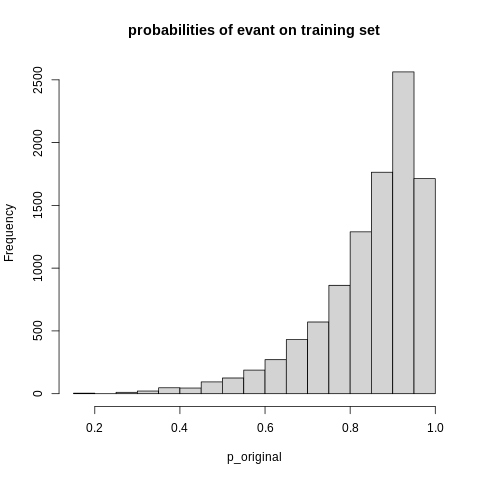

In [15]:
%%R
hist(p_original, main='probabilities of evant on training set')

## comparing the probability set which are associated with validation set
  - 1 updated_p : after converting using CF
  - 2 p_reffited  is provided by refitting a new model on validation set
  - 3 p is probabilities for validation set generated by original model

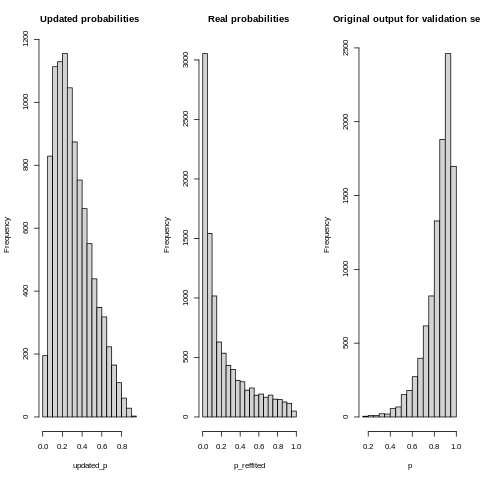

In [16]:
%%R
par(mfrow=c(1,3))

options(repr.plot.width = 2, repr.plot.height =1, repr.plot.res = 600)

hist(updated_p,main="Updated probabilities")
hist(p_reffited,main="Real probabilities ")
hist(p,main="Original output for validation set ")

In [17]:
%%R
print(paste('brier score on original',sum((p-y2)^2)/length(y2)))
print(paste('brier score on updated',sum((updated_p-y2)^2)/length(y2)))
print(paste('brier score on refitted',sum((p_reffited-y2)^2)/length(y2)))

[1] "brier score on original 0.534309445810964"
[1] "brier score on updated 0.127003315282522"
[1] "brier score on refitted 0.112925279131326"


In [18]:
%%R
skewness(p_original)


[1] -1.517189


In [19]:
%%R
skewness(updated_p) 

[1] 0.7047596


In [20]:
%%R
skewness(p_reffited) 

[1] 1.306749


In [21]:
%%R
skewness(p) 

[1] -1.5482


In [22]:
%%R
mean(p_reffited)*(1-mean(p_reffited))

[1] 0.1731047


In [23]:
%%R
mean(p_reffited) 

[1] 0.2227


In [24]:
%%R
beta_params(0.2271, 0.1755256)

$alpha
[1] 1.066728

$beta
[1] 3.630446



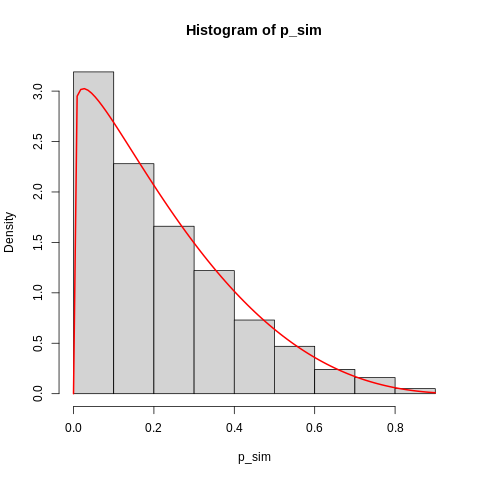

In [25]:
%%R
p_sim <- rbeta(1000, 1.066728,3.630446)
hist(p_sim, freq = FALSE)
curve(dbeta(x,  1.066728,3.630446),
      add = TRUE, col = "red", 
      lwd = 2)